[Datasets](https://www.kaggle.com/paultimothymooney/breast-histopathology-images/)

In [66]:
import os
Root = "../Breast_Cancer_Classification"
os.chdir(Root)

In [2]:
#Import the necessary libraries first

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2
import scipy.integrate
import scipy.special
import h5py as h5
import keras
model = keras.models.load_model('model.h5', custom_objects={'tf': tf})


In [10]:
data = '../Breast_Cancer_Classification/10264'
No_breast_cancer = '../Breast_Cancer_Classification/10264/0/'
Yes_breast_cancer = '../Breast_Cancer_Classification/10264/1'

In [11]:
dirlist=[No_breast_cancer, Yes_breast_cancer]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  1204    labels:  1204


In [12]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(1204,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,../Breast_Cancer_Classification/10264/0/10264_...,No
1,../Breast_Cancer_Classification/10264/0/10264_...,No
2,../Breast_Cancer_Classification/10264/0/10264_...,No
3,../Breast_Cancer_Classification/10264/0/10264_...,No
4,../Breast_Cancer_Classification/10264/0/10264_...,No


In [13]:
print(df['labels'].value_counts())

No     617
Yes    587
Name: labels, dtype: int64


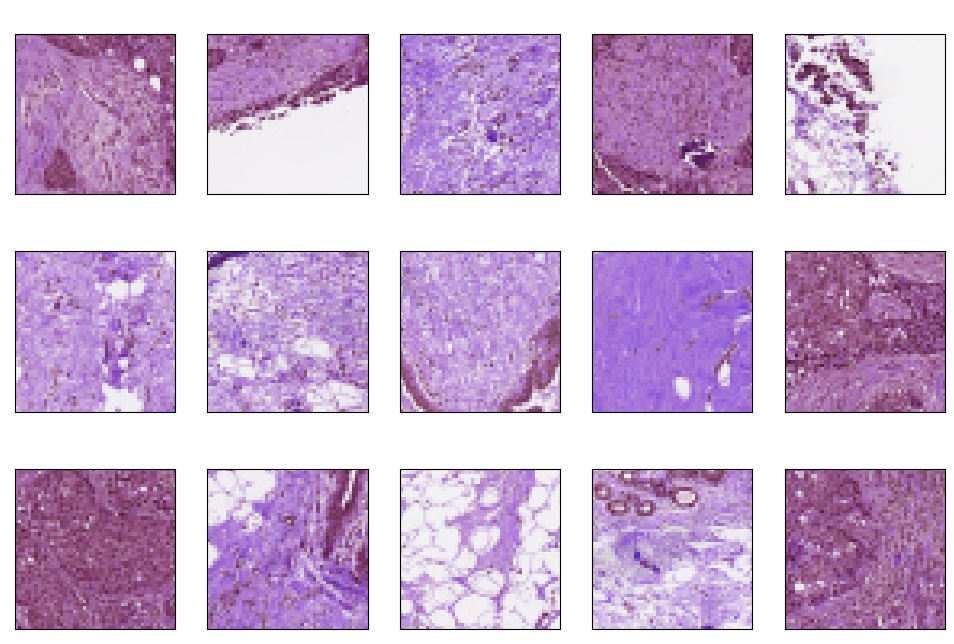

In [14]:
#visualize breast cancer tumor images

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (1028, 2)
test set shape: (61, 2)
validation set shape: (115, 2)


In [16]:

train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [17]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 1028 validated image filenames belonging to 2 classes.
Found 115 validated image filenames belonging to 2 classes.
Found 61 validated image filenames belonging to 2 classes.


In [18]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

**Transfer Learning**

In [19]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_____________________________________________

In [20]:
import scipy

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]




model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100, 
                     callbacks = [callbacks], verbose = 1)

Epoch 1/100
33/33 [==============================] - 110s 3s/step - loss: 0.8466 - accuracy: 0.4893 - val_loss: 0.7757 - val_accuracy: 0.4870
Epoch 2/100
33/33 [==============================] - 117s 4s/step - loss: 0.7150 - accuracy: 0.5506 - val_loss: 0.7003 - val_accuracy: 0.5739
Epoch 3/100
33/33 [==============================] - 125s 4s/step - loss: 0.6713 - accuracy: 0.5953 - val_loss: 0.6525 - val_accuracy: 0.6174
Epoch 4/100
33/33 [==============================] - 129s 4s/step - loss: 0.6460 - accuracy: 0.6255 - val_loss: 0.6028 - val_accuracy: 0.6957
Epoch 5/100
33/33 [==============================] - 112s 3s/step - loss: 0.5915 - accuracy: 0.6877 - val_loss: 0.6176 - val_accuracy: 0.6609
Epoch 6/100
33/33 [==============================] - 118s 4s/step - loss: 0.5705 - accuracy: 0.6955 - val_loss: 0.5406 - val_accuracy: 0.7739
Epoch 7/100
33/33 [==============================] - 129s 4s/step - loss: 0.5451 - accuracy: 0.7247 - val_loss: 0.5085 - val_accuracy: 0.7391
Epoch 

In [21]:
model.save('model.h5')

**Evaluating the model**

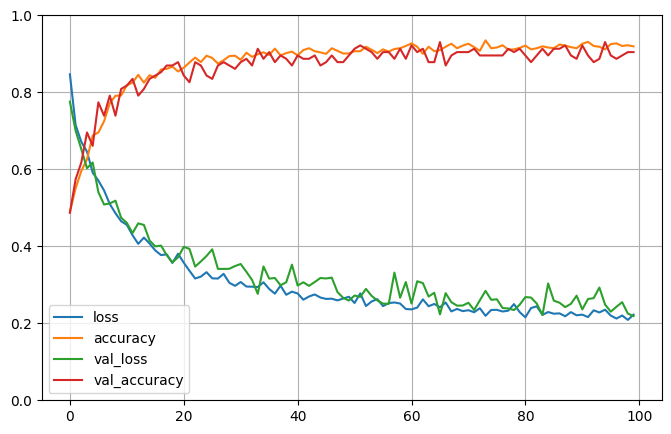

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [26]:
from PIL import Image
model_path = "model.h5"
loaded_model = tf.keras.models.load_model(model_path)

# import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("../Breast_Cancer_Classification/10264/0/10264_idx5_x1001_y551_class0.png")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >= 0.5:
  print("Yes")
else:
  print("No")

1/1 [==============================] - 1s 1s/step
No


In [25]:
train_gen.class_indices

{'No': 0, 'Yes': 1}